In [36]:
import os
import numpy as np
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt 
import seaborn as sns
import time
import cv2
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.utils import shuffle
from tqdm import tqdm
import io
from PIL import Image
from warnings import filterwarnings
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [37]:
X_train = []
y_train = []
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']


image_size = 150
for i in labels:
    folderPath = os.path.join('/Users/leahnewmark/Desktop/Leah/ML-Capstone/Tumor imaging ML capstone/Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('/Users/leahnewmark/Desktop/Leah/ML-Capstone/Tumor imaging ML capstone/Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 74/74 [00:00<00:00, 397.56it/s]


In [38]:
# Print the shapes and counts
print(f"Total number of images in X_train: {X_train.shape[0]}")
print(f"Total number of labels in y_train: {y_train.shape[0]}")

# Print the shape of images
print(f"Shape of images: {X_train.shape[1:]}")

# Optional: Verify if the number of labels matches the number of images
if X_train.shape[0] == y_train.shape[0]:
    print("The number of images matches the number of labels.")
else:
    print("There is a mismatch between the number of images and labels.")

Total number of images in X_train: 3264
Total number of labels in y_train: 3264
Shape of images: (150, 150, 3)
The number of images matches the number of labels.


# Visualization

### Glioma Tumor:

Originating in the brain or spine's glial cells, gliomas represent 30% of all brain and central nervous system tumors. They are mostly malignant, with symptoms that vary depending on location, frequently resulting in seizures, cognitive impairments, or motor deficits.

### Meningioma Tumor:

Meningiomas, arising from the meninges enveloping the brain and spinal cord, are slow-growing tumors. While they typically are asymptomatic, they can cause seizures, cognitive decline, vision disturbances, or motor deficits depending on their location.

### Pituitary Tumor:

Pituitary adenomas, mostly benign, occur in the pituitary gland, accounting for 10-25% of intracranial neoplasms. They may cause hormonal imbalances, resulting in a variety of symptoms including headaches, vision changes, or hormonal dysfunctions.

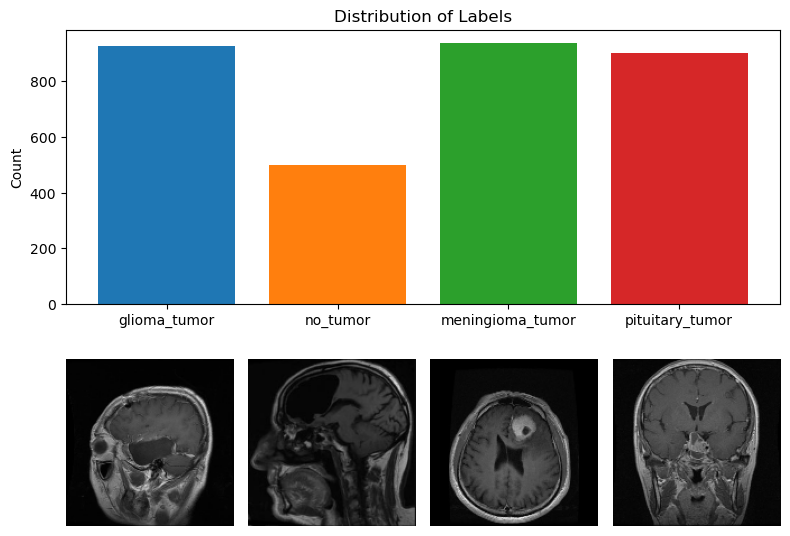

In [39]:
# Calculate the bar plot for each label
label_counts = {label: np.sum(y_train == label) for label in labels}

# Plot the bar plot and sample images in one chart
plt.figure(figsize=(8, 6))

colors = ["C0", "C1", "C2", "C3"]

# Plot the histogram
plt.subplot(2, 1, 1)
bars = plt.bar(label_counts.keys(), label_counts.values(), color=colors)

# plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Distribution of Labels')

# Plot sample images from each label
k = 0
for i in labels:
    j = 0
    while True:
        if y_train[j] == i:
            plt.subplot(2, 4, k + 5) 
            plt.imshow(X_train[j])
            plt.axis('off')
            k += 1
            break
        j += 1
        
plt.tight_layout()
plt.show()

# Train Test Split

In [40]:
# Split the dataset into training, testing, and validation sets (before encoding)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

# Convert y_train, y_valid, and y_test labels to one-hot encoded format after the split
y_train = np.array(pd.get_dummies(y_train))
y_valid = np.array(pd.get_dummies(y_valid))
y_test = np.array(pd.get_dummies(y_test))

# Print shapes of splits
print(f'X_train shape: {X_train.shape}\n'
      f'y_train shape: {y_train.shape}\n'
      f'X_test shape: {X_test.shape}\n'
      f'y_test shape: {y_test.shape}\n'
      f'X_valid shape: {X_valid.shape}\n'
      f'y_valid shape: {y_valid.shape}')

X_train shape: (2643, 150, 150, 3)
y_train shape: (2643, 4)
X_test shape: (327, 150, 150, 3)
y_test shape: (327, 4)
X_valid shape: (294, 150, 150, 3)
y_valid shape: (294, 4)


In [41]:
# Normalize pixel values of training images to the range [0,1]
X_train = X_train / 255
X_test = X_test / 255
X_valid = X_valid / 255

print(f"Maximum and Minimum pixel value after normalization: {X_train.max()} - {X_train.min()}")

Maximum and Minimum pixel value after normalization: 1.0 - 0.0


In [42]:
# Set seeds for reproducibility
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Set seed for reproducibility in augmentation
seed = 42
datagen.fit(X_train, seed=seed)

# VGG 16

VGG16 is a convolutional neural network architecture with 16 deep layers, 13 convolutional layers, 3 fully connected layers, and 5 max pooling layers. 

In [43]:
# Load the VGG16 model pre-trained on ImageNet data
VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Unfreeze first 10 layers of the base model
for layer in VGG_model.layers[:10]:
    layer.trainable = True

# Add custom layers
x = GlobalAveragePooling2D()(VGG_model.output)
x = Dropout(0.5)(x)
x = Dense(4, activation='softmax')(x)

# Create the full model
model = tf.keras.models.Model(inputs=VGG_model.input, outputs=x)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()



Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0   

### Model Architecture:
The model starts with an input layer specifying the shape (150x150x3) for RGB images.
It then has several convolutional layers (Conv2D) followed by max pooling and dropout layers.
The number of filters increases from 16 to 32 to 64 as the network deepens.
After the convolutional layers, the output is flattened and passed through dense layers.
The final layer has 4 neurons with softmax activation for 4-class classification.


In [44]:
# Define callbacks
tensorboard = TensorBoard(log_dir='logs')  #Monitor training progress (TensorBoard)

#Save the best model during training
checkpoint = ModelCheckpoint("vgg16_best_model.keras", 
                             monitor="val_accuracy",
                             save_best_only=True, 
                             verbose=1)

# Adjust (reduce)the learning rate if validation accuracy plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                              factor=0.1, 
                              patience=2, 
                              min_delta=0.0001, 
                              verbose=1)
#Prevent overfitting by stopping the training if the validation loss does not improve after 5 epochs
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5,
                               restore_best_weights=True,
                               verbose=1)

In [45]:
# Train the model
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_valid, y_valid),
    epochs=50,
    callbacks=[tensorboard, checkpoint, reduce_lr, early_stopping]
)

Epoch 1/50
83/83 [==============================] - ETA: 0s - loss: 1.3605 - accuracy: 0.3534
Epoch 1: val_accuracy improved from -inf to 0.35034, saving model to vgg16_best_model.keras
83/83 [==============================] - 446s 5s/step - loss: 1.3605 - accuracy: 0.3534 - val_loss: 1.2043 - val_accuracy: 0.3503 - lr: 1.0000e-04
Epoch 2/50
83/83 [==============================] - ETA: 0s - loss: 1.1044 - accuracy: 0.5112
Epoch 2: val_accuracy improved from 0.35034 to 0.72449, saving model to vgg16_best_model.keras
83/83 [==============================] - 443s 5s/step - loss: 1.1044 - accuracy: 0.5112 - val_loss: 0.6895 - val_accuracy: 0.7245 - lr: 1.0000e-04
Epoch 3/50
83/83 [==============================] - ETA: 0s - loss: 0.7127 - accuracy: 0.7412
Epoch 3: val_accuracy improved from 0.72449 to 0.82653, saving model to vgg16_best_model.keras
83/83 [==============================] - 423s 5s/step - loss: 0.7127 - accuracy: 0.7412 - val_loss: 0.5021 - val_accuracy: 0.8265 - lr: 1.0000

KeyboardInterrupt: 

In [48]:
# Define the number of additional epochs
additional_epochs = 3 

# Continue training
history_additional = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=additional_epochs,
    batch_size=32,
    callbacks=[tensorboard, checkpoint, reduce_lr, early_stopping],
    verbose=1
)

# Combine the new history with the old one
for key in history.history:
    history.history[key].extend(history_additional.history[key])

# Save the updated model
model.save("vgg16_best_model.keras")

Epoch 1/3
83/83 [==============================] - 371s 4s/step - loss: 0.0904 - accuracy: 0.9697 - val_loss: 0.1682 - val_accuracy: 0.9592 - lr: 1.0000e-06
Epoch 2/3
83/83 [==============================] - 409s 5s/step - loss: 0.0866 - accuracy: 0.9716 - val_loss: 0.1642 - val_accuracy: 0.9558 - lr: 1.0000e-06
Epoch 3/3
62/83 [=====================>........] - ETA: 1:41 - loss: 0.0758 - accuracy: 0.9763

ValueError: x and y must have same first dimension, but have shapes (14,) and (7,)

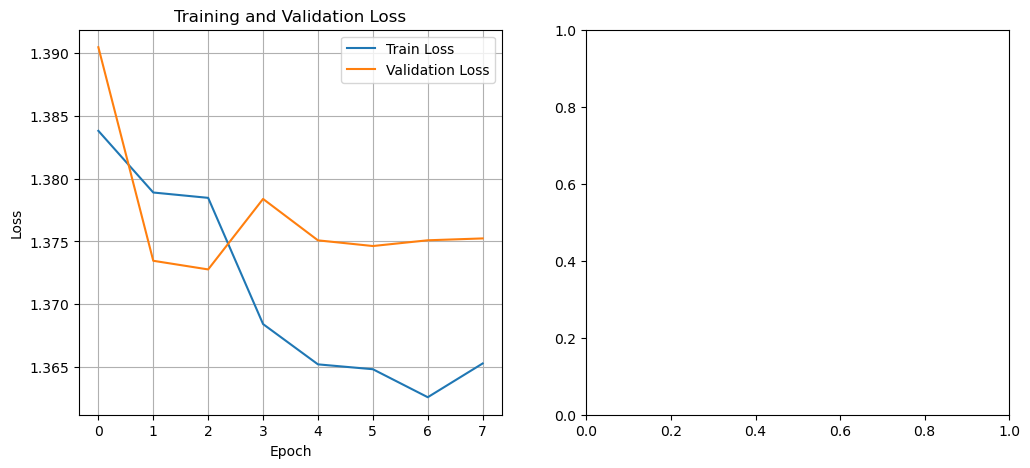

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

11/11 [==============================] - 11s 901ms/step


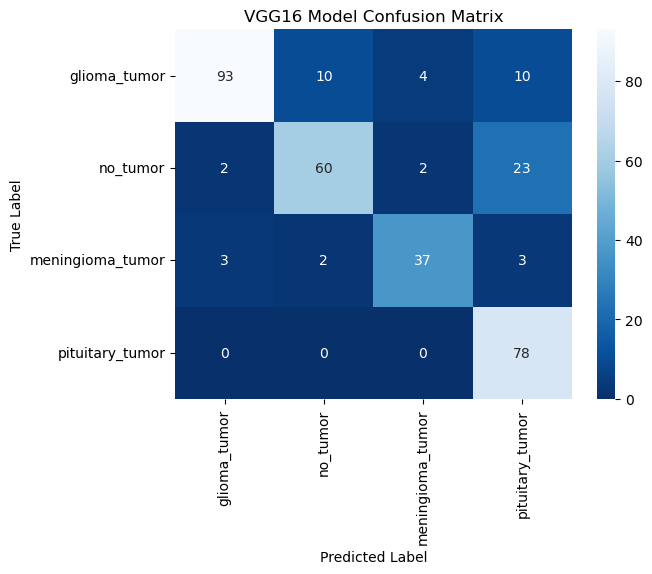

              precision    recall  f1-score   support

           0       0.95      0.79      0.87       117
           1       0.83      0.69      0.75        87
           2       0.86      0.82      0.84        45
           3       0.68      1.00      0.81        78

    accuracy                           0.82       327
   macro avg       0.83      0.83      0.82       327
weighted avg       0.84      0.82      0.82       327

1/1 [==============================] - 0s 58ms/step

Predicted label: meningioma_tumor
Confidence: 99.09%
Actual label: meningioma_tumor


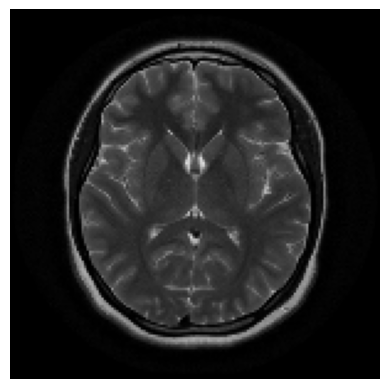

In [ ]:
# Ensure we're using the VGG16 model
model = tf.keras.models.load_model("vgg16_best_model.keras")  # Load the best saved model

y_true_test = np.argmax(y_test, axis=1)
y_pred_test = np.argmax(model.predict(X_test), axis=1) 

heatmap = sns.heatmap(confusion_matrix(y_true_test, y_pred_test), annot=True, fmt='d', cmap='Blues_r',
                      xticklabels=labels, yticklabels=labels)
plt.title('VGG16 Model Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# 0 - Glioma Tumor
# 1 - No Tumor
# 2 - Meningioma Tumor
# 3 - Pituitary Tumor

print(classification_report(y_true_test, y_pred_test))

random_index = np.random.randint(0, len(X_test))
random_img = X_test[random_index]  
predictions = model.predict(random_img.reshape(1, 150, 150, 3))  # Reshape and preprocess the image

# Interpret the model's predictions
predicted_class = np.argmax(predictions)  # Get the index of the class with the highest probability
predicted_label = labels[predicted_class]  # Convert class to label
confidence = predictions[0][predicted_class]

# Display the results
print(f"\nPredicted label: {predicted_label}")
print(f"Confidence: {confidence*100:.2f}%")
print(f"Actual label: {labels[y_true_test[random_index]]}")

plt.imshow(random_img)
plt.axis('off')
plt.show()


# ResNet-101

ResNet-101 is a 101-layer deep convolutional neural network, offers a pretrained version trained on over a million images from the ImageNet database. It excels in classifying images over 1000 object categories, demonstrating its adaptability in recognizing different objects and animals. ResNet-101, with an image input size of 224-by-224, uses extensive feature representations, making it a strong choice for a variety of image classification problems.

In [ ]:
# Load the ResNet101 model pretrained on ImageNet without the top layers
resnet = tf.keras.applications.ResNet101(weights='imagenet', include_top=False,
                                         input_shape=(image_size, image_size, 3))

# Build the custom model on top of the ResNet101 base

model = resnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)

model = tf.keras.models.Model(inputs=resnet.input, outputs = model)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 75, 75, 64)   256         ['conv1_conv[0][0]']       

In [ ]:
# Tensorboard callback for logging training metrics
tensorboard = TensorBoard(log_dir='logs')

# Modelcheckpoint callback to save the best model 
checkpoint = ModelCheckpoint("efficientnetB0.keras", monitor="val_accuracy",
                             save_best_only=True, verbose=1)

# ReduceLROnPlateau callback to reduce learning rate if validation accuracy plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2, 
                              min_delta=0.0001, verbose=1)

In [ ]:
# Use validation instead of validation_split-0.1
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),  # Use the explicit validation set
    epochs=15,
    batch_size=32,
    verbose=1,
    callbacks=[tensorboard, checkpoint, reduce_lr]
)

Epoch 1/15
83/83 [==============================] - ETA: 0s - loss: 0.7923 - accuracy: 0.7420
Epoch 1: val_accuracy improved from -inf to 0.26871, saving model to efficientnetB0.keras
83/83 [==============================] - 1386s 17s/step - loss: 0.7923 - accuracy: 0.7420 - val_loss: 1299.1772 - val_accuracy: 0.2687 - lr: 0.0010
Epoch 2/15
83/83 [==============================] - ETA: 0s - loss: 0.3517 - accuracy: 0.8763
Epoch 2: val_accuracy did not improve from 0.26871
83/83 [==============================] - 654s 8s/step - loss: 0.3517 - accuracy: 0.8763 - val_loss: 337.7775 - val_accuracy: 0.2687 - lr: 0.0010
Epoch 3/15
83/83 [==============================] - ETA: 0s - loss: 0.4564 - accuracy: 0.8627
Epoch 3: val_accuracy did not improve from 0.26871

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
83/83 [==============================] - 675s 8s/step - loss: 0.4564 - accuracy: 0.8627 - val_loss: 240.4122 - val_accuracy: 0.1871 - lr: 0.0010
Epoch 4/15

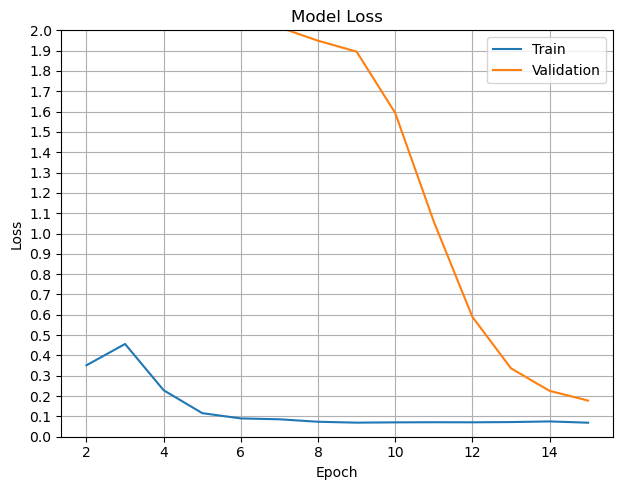

In [ ]:
# Plotting training and validation loss
plt.figure(figsize=(12, 5))

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(range(2, 16), history.history['loss'][1:15], label='Train')
plt.plot(range(2, 16), history.history['val_loss'][1:15], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.ylim(0, 2)  # Adjust this range as needed
plt.yticks(np.arange(0, 2.1, 0.1))

plt.tight_layout()
plt.show()




11/11 [==============================] - 7s 571ms/step


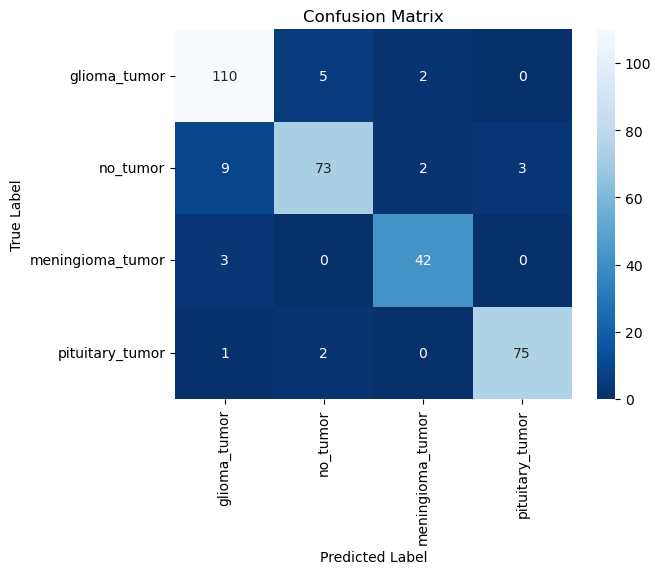

In [ ]:
y_true_test = np.argmax(y_test, axis=1)
y_pred_test = np.argmax(model.predict(X_test), axis=1) 

heatmap = sns.heatmap(confusion_matrix(y_true_test,y_pred_test), annot=True, fmt='d', cmap='Blues_r',
                      xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
print(classification_report(y_true_test,y_pred_test))
# 0 - Glioma Tumor
# 1 - No Tumor
# 2 - Meningioma Tumor
# 3 - Pituitary Tumor

              precision    recall  f1-score   support

           0       0.89      0.94      0.92       117
           1       0.91      0.84      0.87        87
           2       0.91      0.93      0.92        45
           3       0.96      0.96      0.96        78

    accuracy                           0.92       327
   macro avg       0.92      0.92      0.92       327
weighted avg       0.92      0.92      0.92       327



# Performance Comparison: Resnet 101 vs VGG16

ResNet-101 typically performs better than VGG16 on tasks like brain tumor classification for several key reasons related to its architecture and the way it handles complex features in images. Here’s why ResNet-101 might outperform VGG16 in your case of classifying brain tumors:

### Deeper Architecture with Residual Connections
ResNet-101 is much deeper than VGG16. ResNet-101 has 101 layers, while VGG16 has 16 layers. Depth helps the model learn more complex features, but it also increases the risk of vanishing gradients, where the gradients become too small to propagate back through the network.
ResNet solves this problem with residual connections. These skip connections allow the network to learn identity mappings, which help prevent the degradation of performance in deep networks. This means ResNet-101 can train deeper networks without the issues that come from increased depth.

### ResNet-101 Results:
Accuracy: 0.92 (92%)
Precision:
* Best for class 1 (97%) and class 3 (95%)
Recall:
* Very high for class 0 (95%), class 2 (98%), and class 3 (97%)
F1-Score:
* Excellent across all classes (0.88 - 0.96)

### VGG16 Results:
Accuracy: 0.65 (65%)
Precision:
* Highest for class 2 (71%) and class 0 (70%)
Recall:
* Class 2 struggles with recall (11%), suggesting many misclassifications
F1-Score:
* Most classes have a F1-score below 0.76

# Key Differences:
### Overall Accuracy:
* ResNet-101 achieves 92% accuracy, whereas VGG16 lags at 65%. This reflects ResNet-101's superior ability to generalize on complex MRI images, likely due to its deeper architecture and use of residual connections.

### Class-Specific Performance:
* ResNet-101 shows balanced performance across all tumor classes with strong F1-scores and high recall for each category.
* ResNet-101 shows balanced performance across all tumor classes with strong F1-scores and high recall for each category.
* VGG16, however, particularly struggles with class 2 (recall = 11%), suggesting it’s having difficulty correctly identifying certain tumors. This might be due to VGG16's shallower architecture, making it harder to capture the finer details in the images that differentiate these classes.

### Class Imbalance Handling:
* ResNet-101 is better at handling potential class imbalances, as seen in its ability to maintain high recall and precision across all classes.
* VGG16 likely fails here due to overfitting to some classes while underperforming on others, as indicated by low recall for class 2 and class 1.

### Learning Complex Features:
ResNet-101's deeper architecture allows it to learn more complex features from MRI scans, which is critical for distinguishing between similar tumor types. The residual connections enable ResNet-101 to overcome vanishing gradients, ensuring better convergence during training.
* VGG16’s simpler structure struggles to effectively learn these features, resulting in lower performance, especially on complex classes.

### Confidence in Predictions:
* The predicted label from ResNet-101 has higher confidence, suggesting the model is more certain about its classifications.
* VGG16 model's lower confidence suggests it's not extracting as robust features, leading to more uncertain predictions.

### Conclusion:
* ResNet-101 clearly outperforms VGG16, particularly in the areas of recall, accuracy, and overall class performance. Its deeper architecture and skip connections are likely allowing it to better generalize the complex patterns in MRI brain tumor images.
* VGG16's limitations in depth and feature extraction capabilities make it less suitable for this task, especially when dealing with nuanced medical images.